In [1]:
import sys
sys.path.append('../code/functions/')
import tiffIO as io

import math
import cv2
import time
import pickle

import numpy as np
import synapseLib as sl
import matplotlib.pyplot as plt

from scipy.ndimage.filters import maximum_filter

from skimage.exposure import equalize_adapthist
from scipy.signal import convolve
from scipy.stats import linregress

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
data = np.array(io.loadTiff('../data/rr46b_s1_ch1.tif'))

In [3]:
def extractAxons(imgStack, n=2, neighborhood = 16, percentile=80, dilations=5):
    axonProxStack = []
    nthStack = []

    for img in imgStack:
        nthImg = nthAve(img, n, neighborhood, neighborhood)
        dil = cv2.dilate(nthImg, None, iterations=dilations)
        mask = dil > np.percentile(dil, percentile)

        axonProxImg = img * mask
        axonProxStack.append(axonProxImg)

        nthStack.append(nthImg)

    return np.stack(axonProxStack), np.stack(nthStack)


def nthAve(img, n, stepY, stepX):

    out = np.zeros_like(img)
    for yStart in range(0, img.shape[0], stepY):
        curRow = []
        for xStart in range(0, img.shape[1], stepX):
            sub = img[yStart:yStart+stepY, xStart:xStart+stepX]
            out[yStart:yStart+stepY, xStart:xStart+stepX] = np.average(sub)**n
    return np.stack(out)


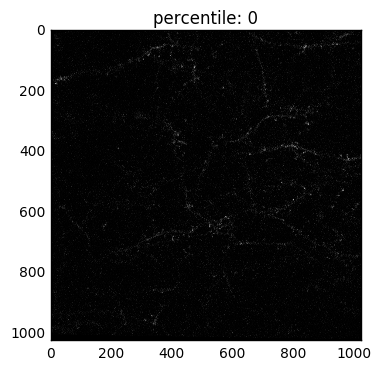

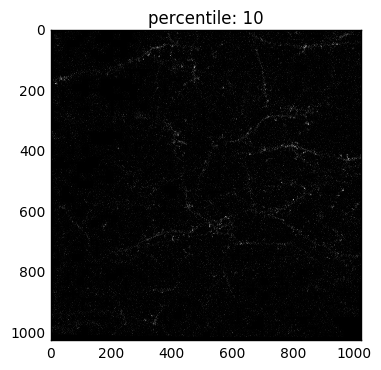

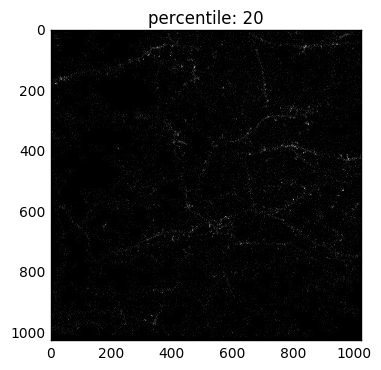

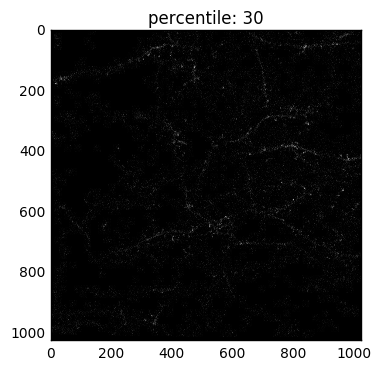

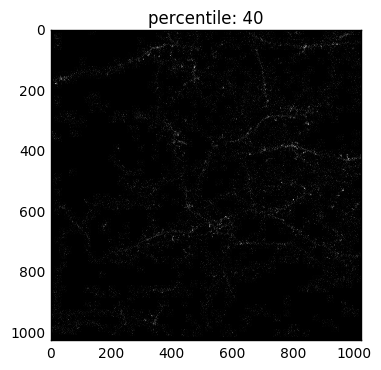

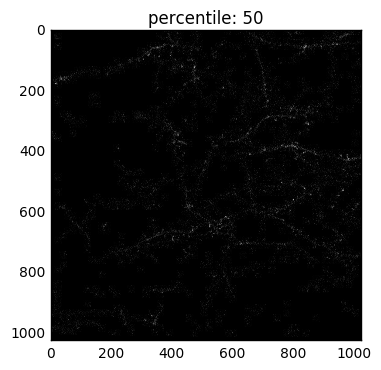

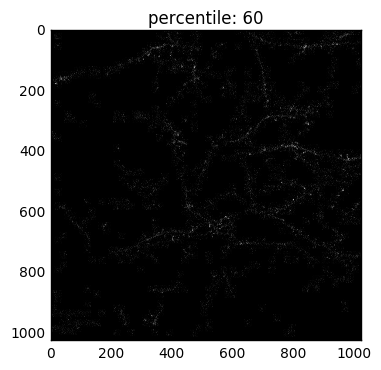

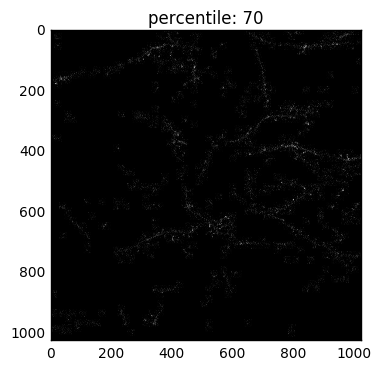

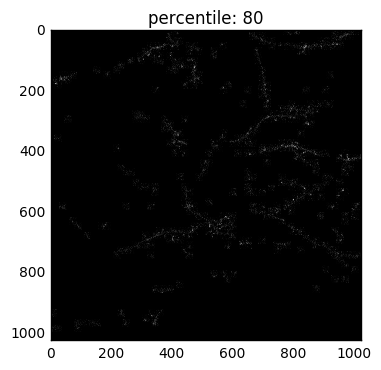

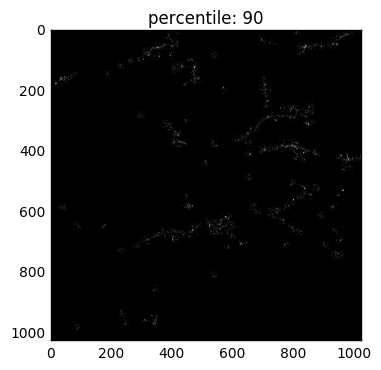

In [4]:
for i in range(0, 100, 10):
    res, _ = extractAxons(data, percentile = i)
    plt.title("percentile: " + str(i))
    plt.imshow(res[9], cmap='gray')
    plt.show()

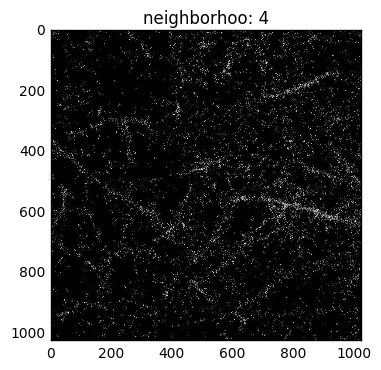

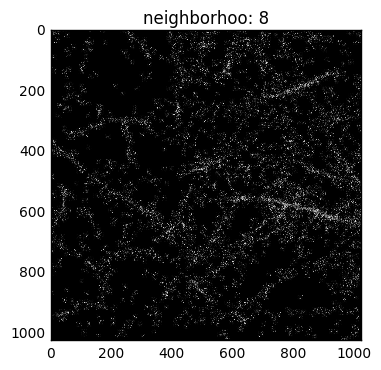

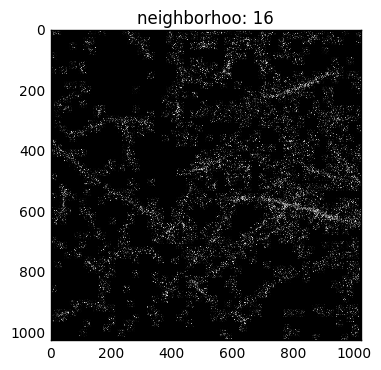

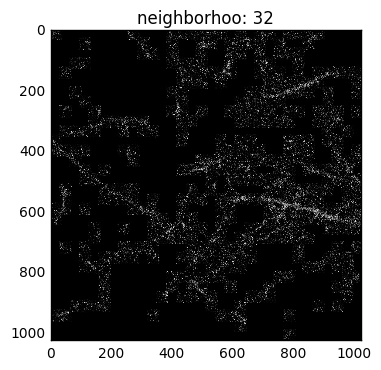

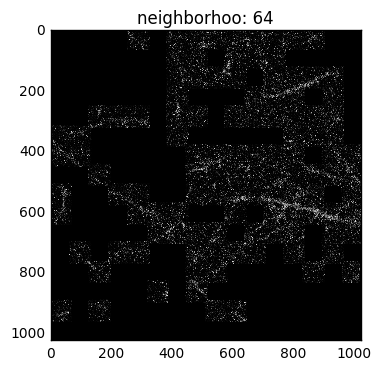

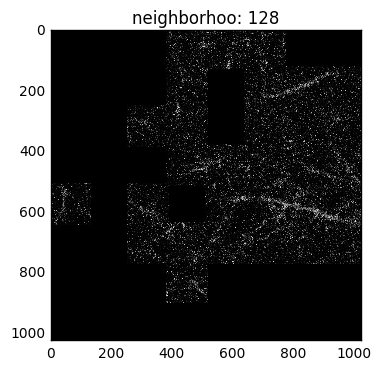

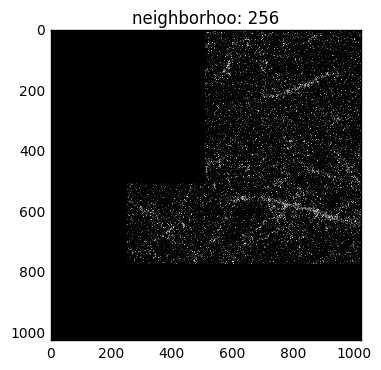

In [5]:
for i in range(2, 9, 1):
    res, _ = extractAxons(data, neighborhood = 2**i, percentile = 50)
    plt.title("neighborhoo: " + str(2**i))
    plt.imshow(np.power(res[20], 2), cmap='gray')
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning:

invalid value encountered in power



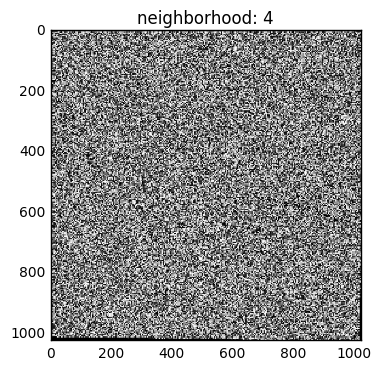

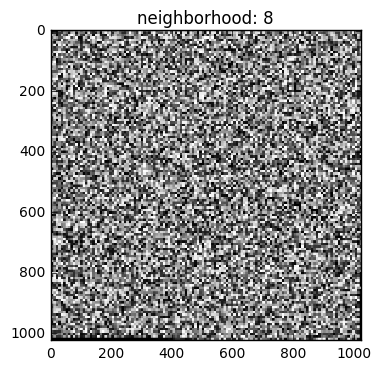

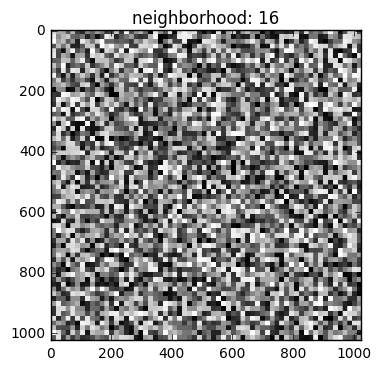

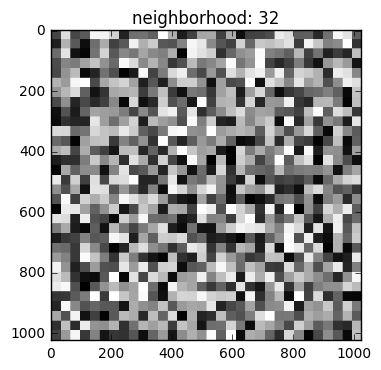

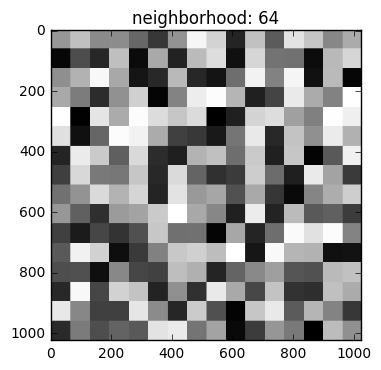

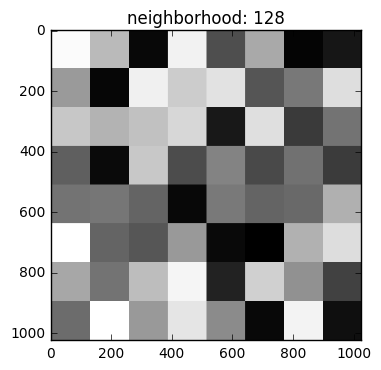

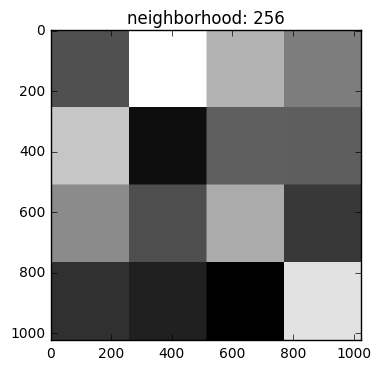

In [6]:
for i in range(2, 9, 1):
    res, dat = extractAxons(data, neighborhood = 2**i, percentile = 50)
    plt.title("neighborhood: " + str(2**i))
    plt.imshow(np.power(dat[20], 2), cmap='gray')
    plt.show()

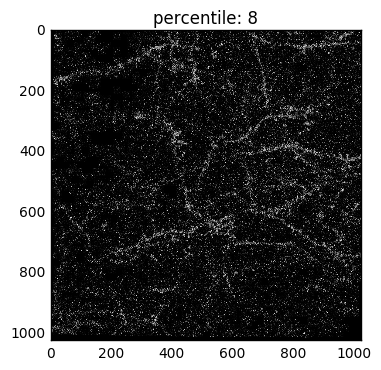

In [7]:
res, _ = extractAxons(data, percentile = i)
plt.title("percentile: " + str(i))
plt.imshow(np.power(res[9], 2), cmap='gray')
plt.show()

In [8]:
res, nth = extractAxons(data, neighborhood = 16, percentile = 50)

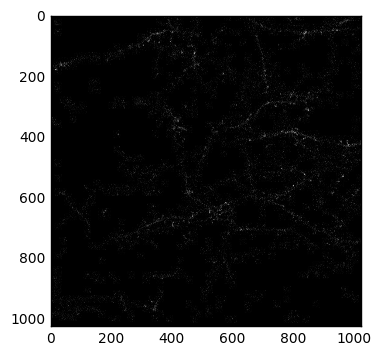

In [9]:
plt.figure()
plt.imshow(res[9], cmap='gray')
plt.show()

In [10]:
segment = sl.segmentAxons(res) 

Parallel took:  456.632004023


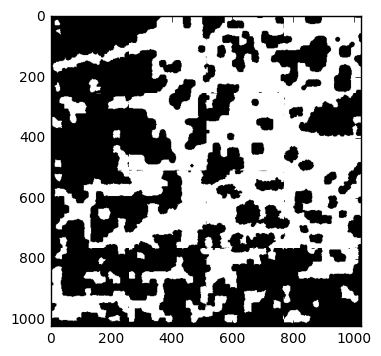

In [11]:
plt.imshow(segment[9], cmap='gray')
plt.show()

In [12]:
equStack = np.stack([equalize_adapthist(img) for img in res])

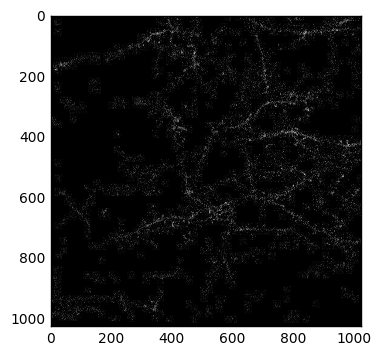

In [13]:
plt.figure()
plt.imshow(equStack[9], cmap='gray')
plt.show()

In [14]:
res, nth = extractAxons(np.stack([equalize_adapthist(elem) for elem in data]), neighborhood = 16, percentile = 50)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning:

Possible precision loss when converting from float64 to uint16



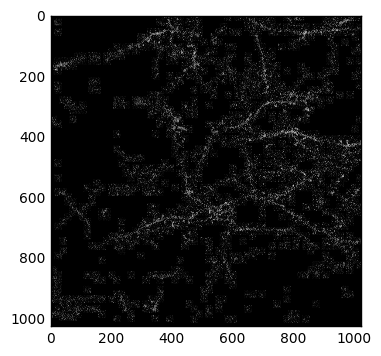

In [15]:
plt.figure()
plt.imshow(equalize_adapthist(res[9]), cmap='gray')
plt.show()

In [16]:
kernel = np.multiply(np.ones((4, 4)), 15)

In [17]:
roadmap = res[9]
for i in range(5):
    roadmap = convolve(roadmap, kernel)

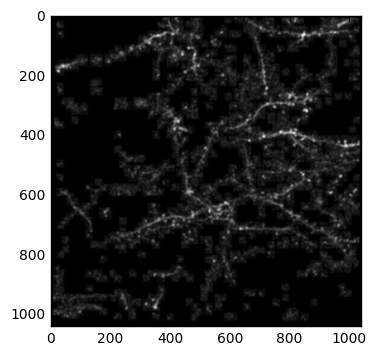

In [18]:
plt.figure()
plt.imshow(roadmap, cmap='gray')
plt.show()

In [19]:
fd, hog_image = hog(res[9], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

NameError: name 'hog' is not defined

In [20]:
plt.figure()
plt.imshow(hog_image, cmap='gray')
plt.show()

NameError: name 'hog_image' is not defined

In [21]:
regionMeans = []
regionMax = []
regionRatio = []
print hog_image.shape
for y in range(0, 1024, 64):
    for x in range(0, 1024, 64):
        sub = hog_image[y:y+64, x:x+64]
        regionMeans.append(np.mean(sub))
        regionMax.append(np.argmax(sub))
        regionRatio.append(np.count_nonzero(sub)/float(4096))

NameError: name 'hog_image' is not defined

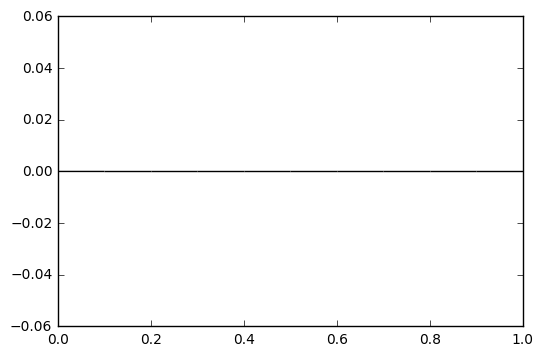

In [22]:
plt.hist(regionRatio)
plt.show()

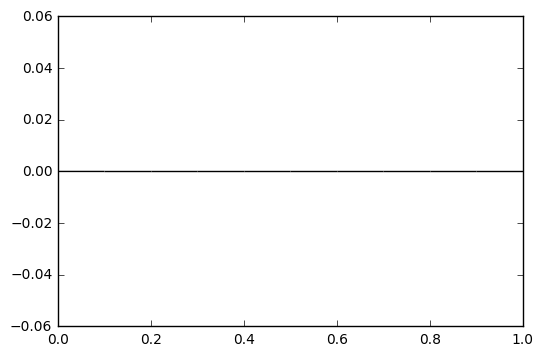

In [23]:
plt.hist(regionMeans)
plt.show()

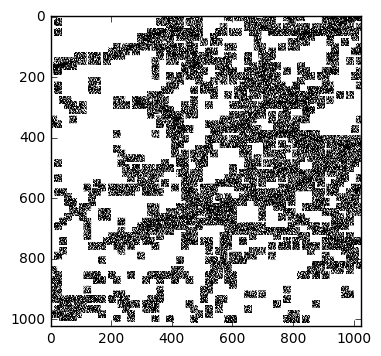

In [24]:
plt.figure()
cat = res[9] != 0
invCat = 1-cat
plt.imshow(invCat, cmap='gray')
plt.show()

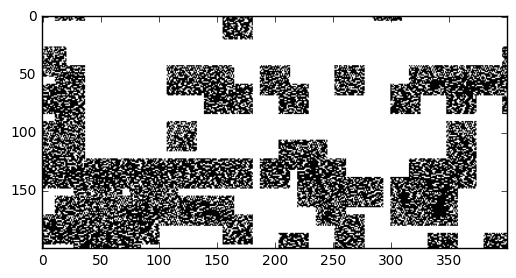

In [25]:
plt.imshow(invCat[800:1000,0:400], cmap='gray')
plt.show()

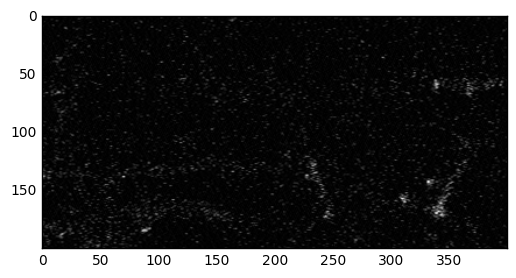

In [26]:
plt.imshow(data[9, 800:1000,0:400], cmap='gray')
plt.show()

In [27]:
blurred = blur = cv2.GaussianBlur(np.multiply(equalize_adapthist(res[9]),255), (5, 5), 0)

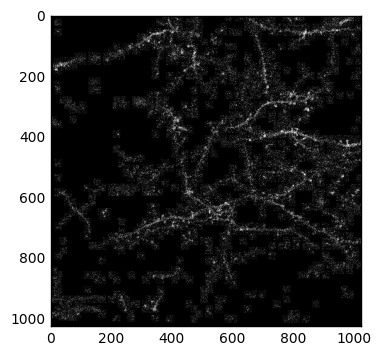

In [28]:
plt.imshow(blur, cmap='gray')
plt.show()

In [29]:
dil = cv2.dilate(blurred, None, iterations=5)

In [30]:
ero = cv2.erode(blurred, None, iterations=1)

In [31]:
magic = equalize_adapthist(np.divide(ero, float(np.max(ero))))

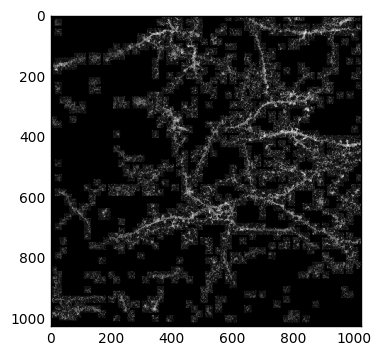

<type 'numpy.ndarray'>


In [32]:
plt.imshow(magic, cmap='gray')
plt.show()
print type(magic)

In [33]:
def sigmoid(x):
    return 1./(1.+math.exp(-x))

In [34]:
out = np.ones_like(magic)
i = 8
for y in range(0, 1024, i):
    for x in range(0, 1024, i):
        cutoff = i**2 * .5
        sub = magic[y:y+i, x:x+i]
        ave = np.average(sub)
        yList, xList = np.nonzero(sub)
        if len(xList) > cutoff and len(yList) > cutoff:
            _, _, r, _, _ = linregress (xList, yList)
            out[y:y+i, x:x+i] = r
        else:
            continue

np.stack(out)
        

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

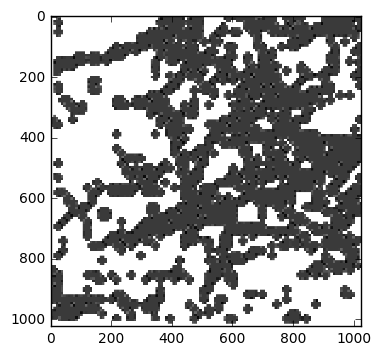

In [35]:
plt.figure()
plt.imshow(out, cmap='gray')
plt.show()

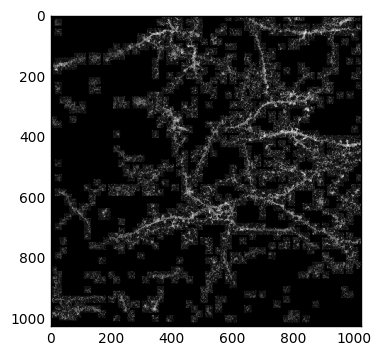

<type 'numpy.ndarray'>


In [36]:
plt.imshow(magic, cmap='gray')
plt.show()
print type(magic)

In [37]:
inv = np.abs(np.subtract(out, 1))

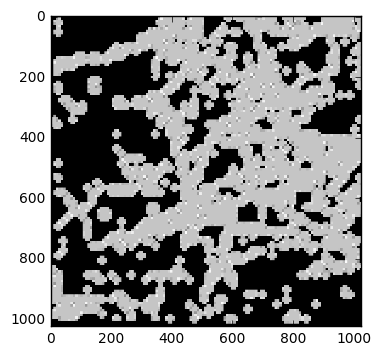

In [38]:
plt.imshow(inv, cmap='gray')
plt.show()


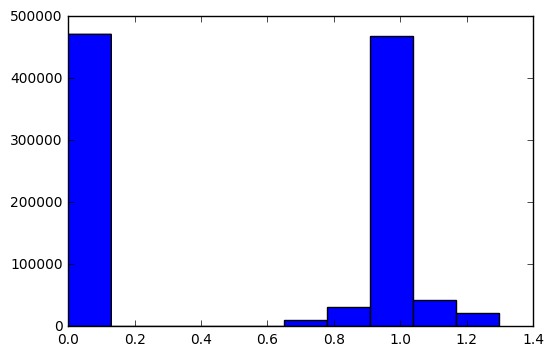

In [39]:
plt.hist(inv.flatten())
plt.show()


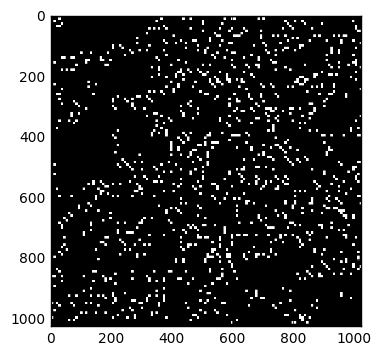

In [40]:
d = np.percentile(inv, 80)
dog = inv > d
plt.imshow(dog, cmap='gray')
plt.show()

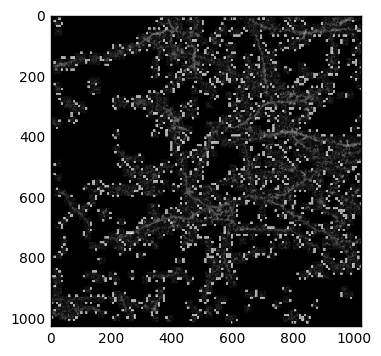

<type 'numpy.ndarray'>


In [41]:
plt.imshow(np.add(magic,dog), cmap='gray')
plt.show()
print type(magic)

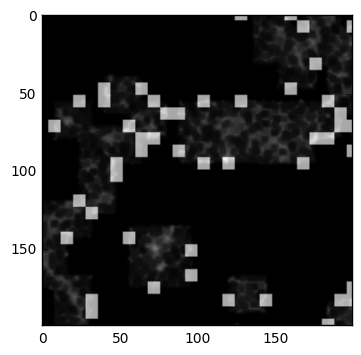

<type 'numpy.ndarray'>


In [42]:
plt.imshow(np.add(magic,dog)[500:700, 100:300], cmap='gray')
plt.show()
print type(magic)

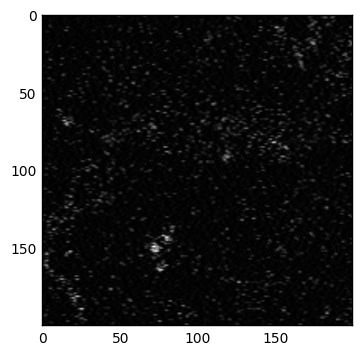

<type 'numpy.ndarray'>


In [43]:
plt.imshow(data[9, 500:700, 100:300], cmap='gray')
plt.show()
print type(magic)